In [ ]:
#%% User settings________________________________________________________________________________________________________
home_path = '/Users/niklas/Virtual_Environment/Version_5/projectAutonomous'
# path_models = '/Users/niklas/Virtual_Environment/Version_5/projectAutonomous/2_Tensorflow/workspace/training/models'
custom_model_name = 'my_ssd_mobilenet_v2_fpnlite'

labels = ['Engine']

## Downscale camera resolution if needed
def setCap720(cap):
    cap.set(3, 1280)
    cap.set(4, 720)


# 0. Install packages manually in virtual environment using jupter notebook
# - This will create folder structure as well
#________________________________________________________________________________________________________________________

#%% Import dependencies
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
import sys

# Setup custom dependencies
import setup
files, paths = setup.createFolderStructure(labels, home_path, 0)

import depthDetectionasModules as cameraSetup

os.chdir(paths['research'])
import object_detection
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Determine latest checkpoint
path_checkpoints = paths['3_Output']+'/'+custom_model_name
files = os.listdir(path_checkpoints)
last_checkpoint = 0
for file in files:
    ckpt = file.split('.')[0]
    try:
        ckpt = ckpt.split('-')[1]
    except:
        # do nothing
        break
    else:
        #print('Current checkpoint: '+ckpt)
        if (int(ckpt) > last_checkpoint):
            last_checkpoint = int(ckpt)
last_checkpoint = 'ckpt-'+str(last_checkpoint)
print('Found latest checkpoint: '+last_checkpoint)

# Load pipeline config and build a detection model
path_pipeline = paths['3_Output']+'/'+custom_model_name+'/pipeline.config'
configs = config_util.get_configs_from_pipeline_file(path_pipeline)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(path_checkpoints, str(last_checkpoint))).expect_partial()

#@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Initiate detection
path_labelmap = paths['3_Output']+'/'+custom_model_name+'/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(path_labelmap)

In [6]:
!pip install pyqt5
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
cameraMatrixL, newCameraMatrixL, distortionCoefficientsL = cameraSetup.getIntrinsicsLeft(paths)
cameraMatrixR, newCameraMatrixR, distortionCoefficientsR = cameraSetup.getIntrinsicsRight(paths)
print('Imported camera intrinsics matrices...')


# Load geometric stereo properties
Rot, Trns, Emat, Fmat = cameraSetup.getStereoProperties(paths, cameraMatrixL, newCameraMatrixL, distortionCoefficientsL, cameraMatrixR, newCameraMatrixR, distortionCoefficientsR)
print('Imported geometric stereo parameters...')

# Load rectification map
Left_Stereo_Map, Right_Stereo_Map, Q = cameraSetup.getRectificationMap(paths, cameraMatrixL, newCameraMatrixL, distortionCoefficientsL, cameraMatrixR, newCameraMatrixR, distortionCoefficientsR, Rot, Trns, Emat, Fmat)
print('Imported rectification maps...')

In [ ]:
img = cv.imread('/Users/niklas/Virtual_Environment/Version_5/projectAutonomous/Depth_measurement/camL75.png')
image_np = np.array(img)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [ ]:
viz_utils.__file__

In [ ]:
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

image_np_with_detections, aryfound = viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

print(aryfound)

plt.figure(figsize=(32, 32))
plt.axis('off')
plt.imshow(cv.cvtColor(image_np_with_detections, cv.COLOR_BGR2RGB))
plt.show()

In [ ]:
width = image_np_with_detections.shape[1]
height = image_np_with_detections.shape[0]

margin = 10 #pixels

xmin = int(round(aryfound['xmin']*width))-margin
xmax = int(round(aryfound['xmax']*width))+margin
ymin = int(round(aryfound['ymin']*height))-margin
ymax = int(round(aryfound['ymax']*height))+margin

In [7]:
img_piece = image_np[ymin:ymax, xmin:xmax]
plt.figure()
plt.axis('off')
plt.imshow(cv.cvtColor(img_piece, cv.COLOR_BGR2RGB))
plt.show()

NameError: name 'image_np' is not defined

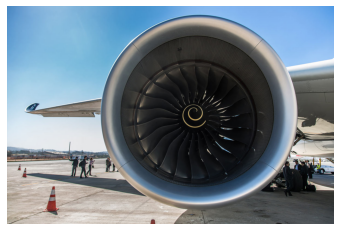

In [8]:
img = cv.imread('/Users/niklas/Virtual_Environment/Version_5/primary.jpeg')
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

#ret, thresh = cv.threshold(gray, 175, 255, 0)
#contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#cv.drawContours(gray, contours, -1, (0,255,0), 3)

plt.figure('T')
plt.axis('off')
plt.imshow(rgb)
plt.show()

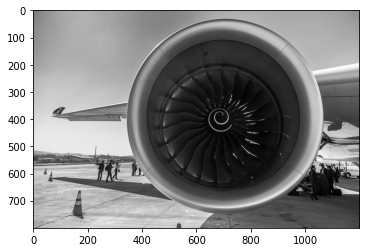

In [9]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
plt.show()

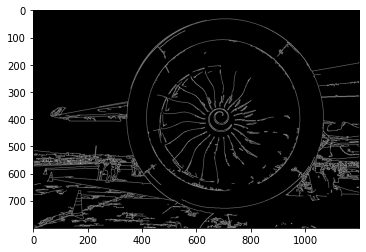

952
[[[721 798]]

 [[721 799]]

 [[722 798]]

 [[723 799]]

 [[722 798]]]
[[[672 798]]

 [[671 799]]

 [[670 799]]

 [[671 799]]

 [[672 798]]

 [[674 798]]

 [[675 799]]

 [[675 798]]]
[[[678 797]]

 [[682 797]]]
[[[ 989  795]]

 [[ 988  796]]

 [[ 987  796]]

 [[ 987  798]]

 [[ 990  798]]

 [[ 991  799]]

 [[ 996  799]]

 [[ 991  799]]

 [[ 990  798]]

 [[ 988  798]]

 [[ 987  797]]

 [[ 988  796]]

 [[ 989  796]]

 [[ 990  795]]

 [[ 999  795]]

 [[1000  796]]

 [[1003  796]]

 [[1004  797]]

 [[1006  797]]

 [[1008  799]]

 [[1011  799]]

 [[1009  799]]

 [[1008  798]]

 [[1007  798]]

 [[1006  797]]

 [[1004  797]]

 [[1003  796]]

 [[1000  796]]

 [[ 999  795]]]
[[[554 795]]

 [[554 797]]

 [[553 798]]

 [[553 799]]

 [[553 798]]

 [[554 797]]

 [[555 798]]

 [[555 799]]

 [[555 798]]

 [[556 797]]

 [[557 797]]

 [[556 797]]

 [[555 798]]

 [[554 797]]]
[[[560 794]]

 [[559 795]]

 [[556 795]]

 [[560 795]]

 [[561 796]]

 [[560 797]]

 [[565 797]]

 [[567 799]]

 [[568 799]]



[[[873 173]]

 [[874 172]]

 [[878 176]]

 [[877 177]]

 [[876 177]]

 [[873 174]]]
[[[869 170]]

 [[870 169]]

 [[873 172]]

 [[873 173]]

 [[872 174]]

 [[869 171]]]
[[[867 169]]

 [[868 168]]

 [[869 168]]

 [[870 169]]

 [[869 170]]

 [[868 170]]]
[[[837 149]]

 [[838 148]]

 [[839 148]]

 [[840 149]]

 [[841 149]]

 [[843 151]]

 [[842 152]]

 [[841 152]]

 [[840 151]]

 [[839 151]]]
[[[820 140]]

 [[821 139]]

 [[822 139]]

 [[823 140]]

 [[822 141]]

 [[821 141]]]
[[[557  75]]

 [[555  77]]

 [[554  77]]

 [[553  78]]

 [[552  78]]

 [[551  79]]

 [[550  79]]

 [[549  80]]

 [[548  80]]

 [[547  81]]

 [[544  81]]

 [[542  83]]

 [[541  83]]

 [[539  85]]

 [[538  85]]

 [[537  86]]

 [[536  86]]

 [[535  87]]

 [[534  87]]

 [[533  88]]

 [[532  88]]

 [[530  90]]

 [[529  90]]

 [[527  92]]

 [[526  92]]

 [[525  93]]

 [[524  93]]

 [[523  94]]

 [[522  94]]

 [[521  95]]

 [[519  95]]

 [[518  96]]

 [[517  96]]

 [[517  97]]

 [[516  98]]

 [[514  98]]

 [[514  99]]

 [[512

In [30]:
blur = cv.GaussianBlur(gray, (1,1), cv.BORDER_DEFAULT)
canny = cv.Canny(blur, 50, 250)
plt.imshow(cv.cvtColor(canny, cv.COLOR_BGR2RGB))
plt.show()

ret, thresh = cv.threshold(canny, 127, 255, 0)
#contours, hierarchies = cv.findContours(canny, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(len(contours))
for contour in contours:
    print(contour)

952


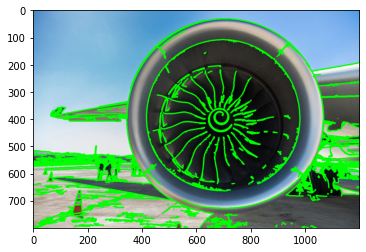

In [27]:
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print(len(contours))
for contour in contours:
    if cv.contourArea(contour) > 2070:
        cv.drawContours(rgb, contours, -1, (0,255,0), 3)
plt.imshow(rgb)
plt.show()

In [ ]:
img = cv.imread('/Users/niklas/Virtual_Environment/Version_5/primary.jpeg')
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

circles = cv.HoughCircles(canny, cv.HOUGH_GRADIENT, 1, gray.shape[0] / 8,
                           param1=100, param2=30,
                           minRadius=25)
    
    
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(rgb, center, 1, (0, 100, 100), 3)
        # circle outline
        radius = i[2]
        cv.circle(rgb, center, radius, (255, 0, 255), 3)
plt.imshow(rgb)
plt.show()

In [ ]:
print(len(contours))